In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from local_plot import *
from utils import *


Drone,Traj. Len,ATE Pos,ATE Att,Cov/m: x,y,z,PGO:ATE Pos,ATE Att
1by1,15.0m,0.106,16.462,4.6e-03,3.5e-03,2.5e-03,nan,nan°
2by1,12.0m,0.124,18.286,1.5e-02,1.8e-03,5.0e-03,nan,nan°
3by1,10.3m,0.130,18.022,3.9e-03,7.8e-03,1.6e-03,nan,nan°
4by1,12.8m,0.120,16.092,4.0e-03,7.0e-03,4.0e-03,nan,nan°


Relative,EST RMSE: Pos (XYZ),POS,Ang,BIAS: Pos,Ang
1->2,"0.057,0.036,0.053",0.086,4.02°,"-0.015,-0.001,-0.031",-3.06°
1->3,"0.051,0.041,0.055",0.085,3.80°,"0.020,-0.006,-0.038",-19.88°
1->4,"0.039,0.030,0.049",0.069,3.66°,"-0.002,-0.007,-0.024",+2.26°


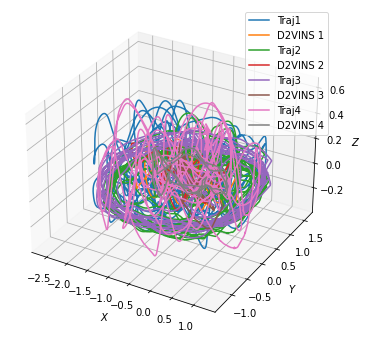

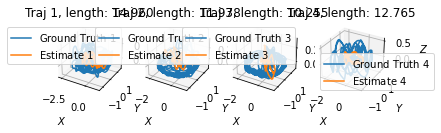

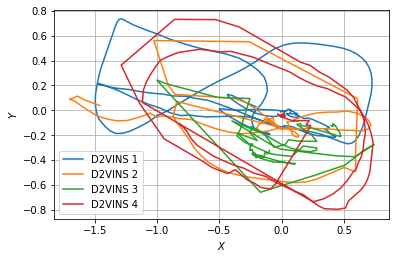

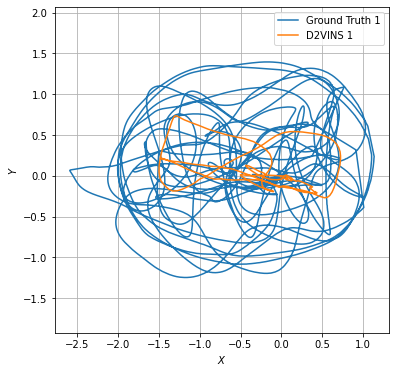

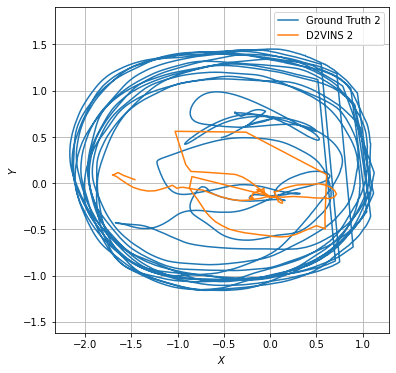

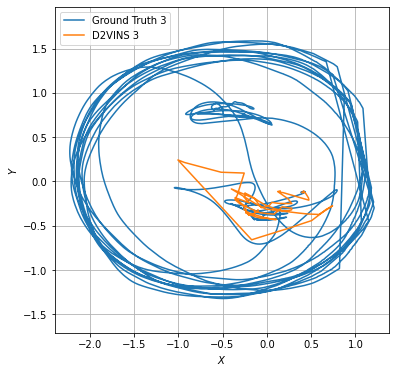

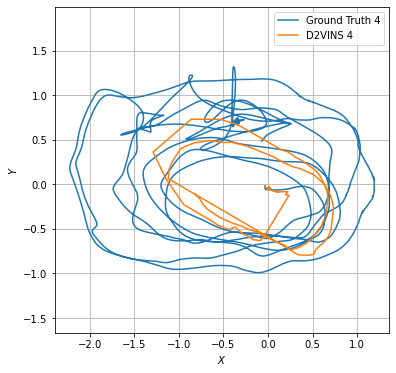

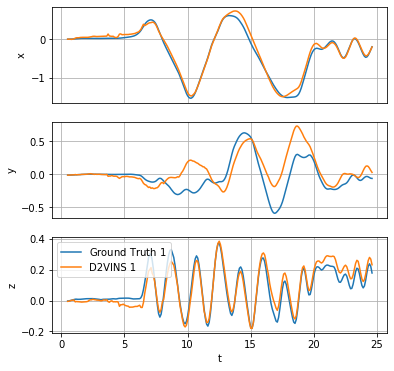

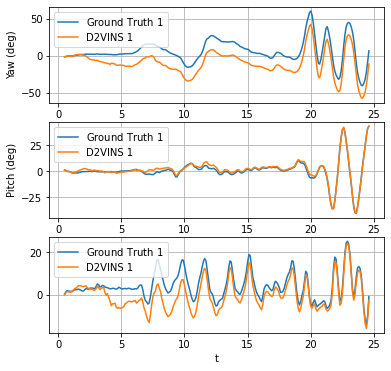

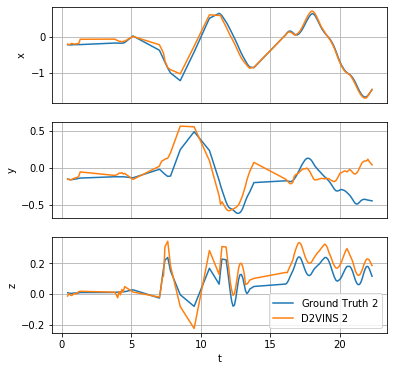

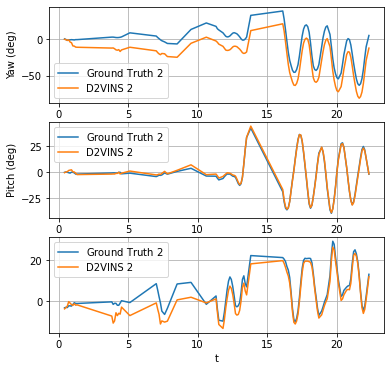

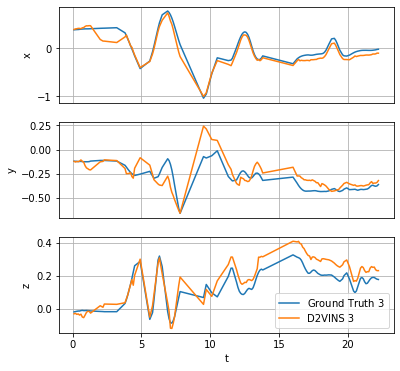

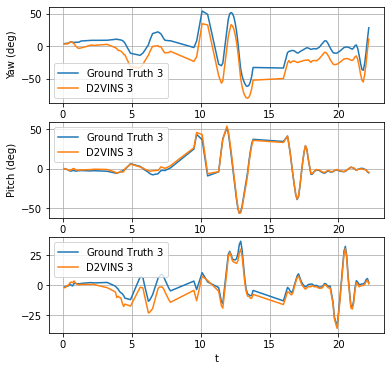

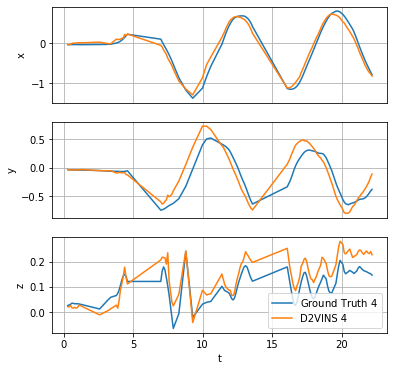

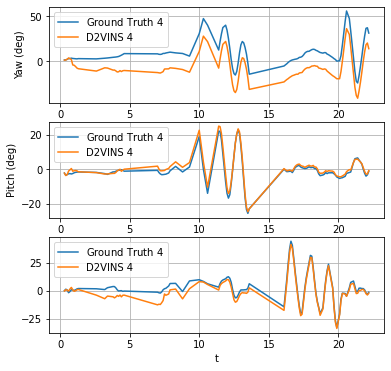

In [7]:
nodes = [1, 2, 3, 4]
output_folder = "/home/xuhao/data/tum_datasets/outputs/d2vins/swarm1"
data_folder="/home/xuhao/data/tum_datasets/"
dte = 30
paths_gt, t0 = read_paths(data_folder, nodes, prefix="groundtruth")
paths, _ = read_paths(output_folder, nodes, t0=t0)
display(plot_fused_err(nodes, paths, paths_gt,dte=dte, show=False, outlier_thres_yaw=0.6, outlier_thres=0.2))
display(plot_relative_pose_err(1, nodes[1:], paths, paths_gt,dte=dte, show=False, outlier_thres=0.2, outlier_yaw_thres=0.2))
plot_fused(nodes, paths, poses_gt=paths_gt)
